In [175]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import math as math
import itertools
import os
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy import optimize

In [95]:
## Import visible matter profiles and plot them

input_folder = './digitized_luminous_matter_profiles/'
output_folder = './comparison_luminous_matter_profiles/'

input_CSVs = ['BH.csv', 'inner bulge.csv', 'bulge.csv', 'disk.csv']
output_CSVs = ['BH.csv', 'inner bulge.csv', 'bulge.csv', 'disk.csv']

lower_bounds = [0.00034, 0.001, 0.001, 0.001]    # minimum raddi [kpc]
upper_bounds = [10.58, 0.07, 1.97, 15.68]        # maximum radii (step size of 0.005 kpc)
radius = np.linspace(0.00034, 15.68, 400000)     # Radii array (400000 elements)

for i in range(len(CSVs)):

    input_file = input_folder + input_CSVs[i]
    output_file = output_folder + output_CSVs[i]

    df = np.genfromtxt(input_file, delimiter=',')
    df_x, df_y = [], []

    for i in range(len(df)):
        df_x.append(df[i][0])
        df_y.append(df[i][1])

    comparison_points = np.interp(radius, df_x, df_y)

    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)

        for i in range(len(radius)):
            writer.writerow([radius[i], comparison_points[i]])

    print(len(radius), len(comparison_points))

400000 400000
400000 400000
400000 400000
400000 400000


<Figure size 640x480 with 0 Axes>

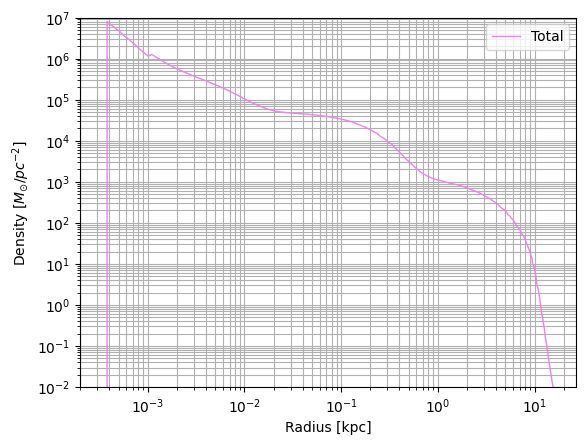

In [100]:
## Plot the density profiles

folder = './comparison_luminous_matter_profiles/'
CSVs = ['BH.csv', 'inner bulge.csv', 'bulge.csv', 'disk.csv']
labels = ['Black Hole', 'Inner Bulge', 'Bulge', 'Disk']
colors = ['red', 'orange', 'green', 'blue']

fig, ax = plt.subplots()
plt.xlabel('Radius [kpc]')
plt.ylabel('Density [$M_{\odot}/pc^{-2}$]')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')
ax.set_xscale('log')
ax.set_yscale('log')

totalDensity = np.zeros(400000)

for i in range(len(CSVs)):

    file = folder + CSVs[i]
    df = np.genfromtxt(file, delimiter=',')
    df_x, df_y = [], []

    for j in range(len(df)):
        df_x.append(df[j][0])
        df_y.append(df[j][1])

    for j in range(len(totalDensity)):
        totalDensity[j] = totalDensity[j] + df_y[j]

    plt.plot(df_x, df_y, label=labels[i], color=colors[i], alpha=1, linewidth=1)

plt.legend(loc='upper right')
plt.savefig('./figures/vis_density_dists.pdf',dpi=100,bbox_inches='tight')
plt.clf()

fig, ax = plt.subplots()
plt.xlabel('Radius [kpc]')
plt.ylabel('Density [$M_{\odot}/pc^{-2}$]')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1e-2, 1e7)
plt.plot(df_x, totalDensity, label='Total', color='violet', alpha=1, linewidth=1)
plt.legend(loc='upper right')
plt.savefig('./figures/total_vis_density_dist.pdf',dpi=100,bbox_inches='tight')
plt.show()

In [101]:
## Get mass enclosed: this requires converting from pc^-2 to kpc^-2 (our radius is measured in kpc, but density mesaured in pc)

step_size = df_x[1]-df_x[0]
mass, mass_enclosed = [], []
radius_chopped = []

i = 0
while i < (len(totalDensity)):
    mass.append( totalDensity[i] * 2 * math.pi * radius[i] * step_size * 1000**2 )
    mass_enclosed.append( np.sum(mass) )
    radius_chopped.append( radius[i] )
    i = i + 1

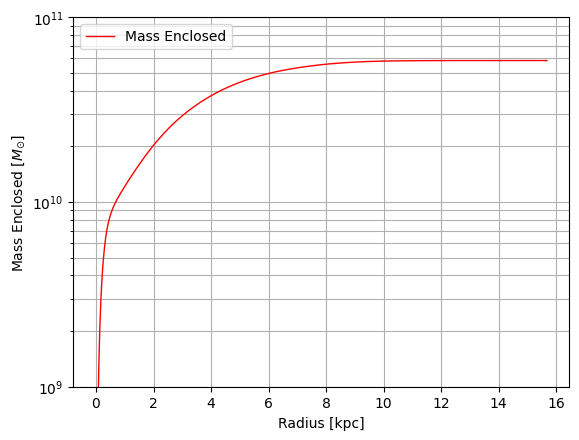

In [110]:
## Plot mass enclosed

fig, ax = plt.subplots()
plt.xlabel('Radius [kpc]')
plt.ylabel('Mass Enclosed [$M_{\odot}$]')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')
#ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1e9,1e11)
plt.plot(radius_chopped, mass_enclosed, label='Mass Enclosed', color='red', alpha=1, linewidth=1)
plt.legend(loc='upper left')
plt.savefig('./figures/vis_mass_enclosed (lin x-axis).pdf',dpi=100,bbox_inches='tight')
plt.show()

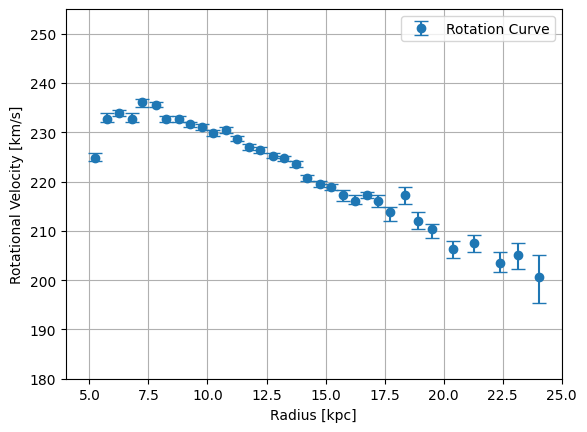

In [184]:
## Plot the digitized velocity curve with uncertainty

file = './rotation curve 2.csv'

df = np.genfromtxt(file, delimiter=',')
radius, velocity, lower, upper = [], [], [], []
lower_err, upper_err = [], []

for i in range(len(df)):
    radius.append( df[i][0] )
    velocity.append( df[i][1] )
    lower.append( df[i][2] )
    upper.append( df[i][3] )

for i in range(len(velocity)):
    lower_err.append( df[i][1] - df[i][2] )
    upper_err.append( df[i][3] - df[i][1] )

for i in range(len(lower_err)):
    if lower_err[i] < 0:
        print(i)
    if upper_err[i] < 0:
        print(i)

fig, ax = plt.subplots()
plt.xlabel('Radius [kpc]')
plt.ylabel('Rotational Velocity [km/s]')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')
plt.ylim(180,255)
plt.xlim(4,25)

plt.errorbar(radius, velocity, yerr=[lower_err, upper_err], fmt='o', capsize=5, label='Rotation Curve')
plt.legend(loc='upper right')
plt.savefig('./figures/digitized_rotation_curve.pdf',dpi=100,bbox_inches='tight')
plt.show()

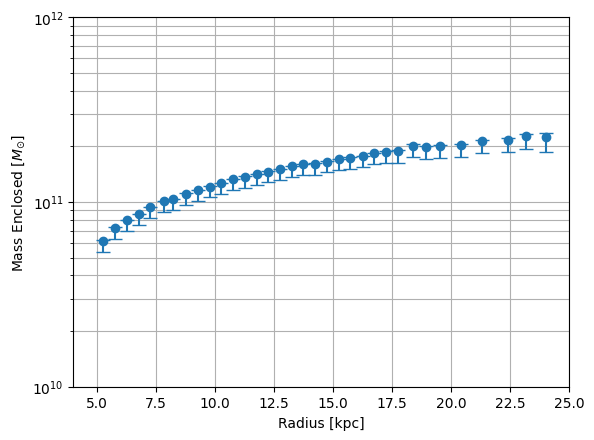

In [186]:
## Get the total mass enclosed

G = 4.3009e-3  # in units pc (km/s)^2 Mdot^-1
G_lower, G_upper = 4.30095e-3, 4.90085e-3
totalMass, totalMassLower, totalMassUpper = [], [], []
upper_err, lower_err = [], []

def massFunc(r,v,G):
    return v**2 * r / G

for i in range(len(radius)):
    totalMass.append( massFunc(1000*radius[i], velocity[i], G) )
    totalMassLower.append( massFunc(1000*radius[i], lower[i], G_upper) )
    totalMassUpper.append( massFunc(1000*radius[i], upper[i], G_lower) )

for i in range(len(totalMass)):
    upper_err.append(totalMassUpper[i]-totalMass[i])
    lower_err.append(totalMass[i]-totalMassLower[i])

fig, ax = plt.subplots()
plt.xlabel('Radius [kpc]')
plt.ylabel('Mass Enclosed [$M_{\odot}$]')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')
plt.ylim(1e10, 1e12)
plt.xlim(4,25)
ax.set_yscale('log')

plt.errorbar(radius, totalMass, yerr=[lower_err, upper_err], fmt='o', capsize=5)
plt.savefig('./figures/total_mass_enclosed.pdf',dpi=100,bbox_inches='tight')
plt.show()

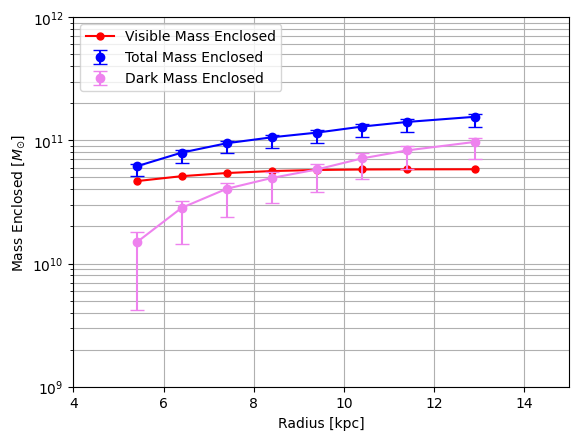

In [152]:
comparison_points = []
for i in range(len(radius)):

    for j in range(len(radius_chopped)):

        if radius[i] <= radius_chopped[j]:
            comparison_points.append( mass_enclosed[j] )
            break

DM, DM_lower, DM_upper = [], [], []
DM_lower_err, DM_upper_err = [], []

for i in range(len(totalMass)):
    DM.append(totalMass[i]-comparison_points[i])
    DM_lower.append(totalMassLower[i]-comparison_points[i])
    DM_upper.append(totalMassUpper[i]-comparison_points[i])

for i in range(len(totalMass)):
    DM_lower_err.append(DM[i]-DM_lower[i])
    DM_upper_err.append(DM_upper[i]-DM[i])

fig, ax = plt.subplots()
plt.xlabel('Radius [kpc]')
plt.ylabel('Mass Enclosed [$M_{\odot}$]')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')
#ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1e9, 1e12)
plt.xlim(4,15)

plt.plot(radius, comparison_points, marker='o', label='Visible Mass Enclosed', color='red', alpha=1, markersize=5)
plt.errorbar(radius, totalMass, yerr=[lower_err, upper_err], fmt='o', capsize=5, label='Total Mass Enclosed', color='blue')

plt.plot(radius, DM, linewidth=1.5, color='violet')
plt.errorbar(radius, DM, yerr=[DM_lower_err, DM_upper_err], fmt='o', capsize=5, label='Dark Mass Enclosed', color='violet')

plt.plot(radius, totalMass, linewidth=1.5, color='blue')

plt.legend(loc='upper left')
#plt.savefig('./figures/vis, dark, total mass.pdf',dpi=100,bbox_inches='tight')
plt.show()

In [160]:
# Make 'shell' plots

spheres, shells = [], []
mass_shells, mass_shells_lower, mass_shells_upper = [], [], []

for element in radius:
    spheres.append(4/3 * math.pi * element**3)

shells.append(spheres[0])
mass_shells.append(DM[0])
mass_shells_lower.append(DM_lower[0])
mass_shells_upper.append(DM_upper[0])

i=1
while i <= 7:
    shells.append(spheres[i]-spheres[i-1])
    mass_shells.append(DM[i]-DM[i-1])
    mass_shells_lower.append(DM_lower[i]-DM_lower[i-1])
    mass_shells_upper.append(DM_upper[i]-DM_upper[i-1])
    i = i + 1

mass_shells_lower_err, mass_shells_upper_err = [], []

for i in range(len(mass_shells)):
    mass_shells_lower_err.append(mass_shells[i]-mass_shells_lower[i])
    mass_shells_upper_err.append(mass_shells_upper[i]-mass_shells[i])

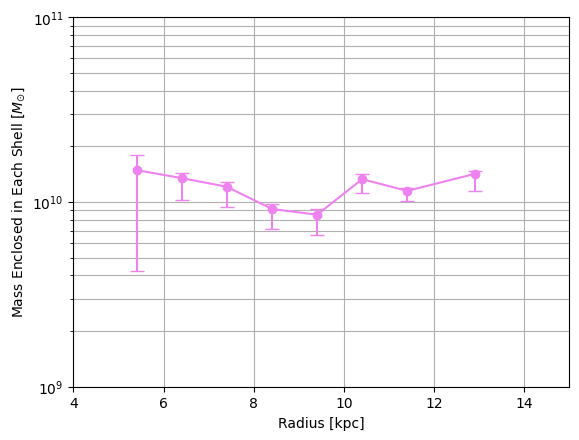

In [170]:
## Plot mass per shell

fig, ax = plt.subplots()
plt.xlabel('Radius [kpc]')
plt.ylabel('Mass Enclosed in Each Shell [$M_{\odot}$]')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')
#ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1e9, 1e11)
plt.xlim(4,15)

plt.plot(radius, mass_shells, linewidth=1.5, color='violet')
plt.errorbar(radius, mass_shells, yerr=[mass_shells_lower_err, mass_shells_upper_err], fmt='o', capsize=5, color='violet')
plt.savefig('./figures/dark mass per shell.pdf',dpi=100,bbox_inches='tight')
plt.show()

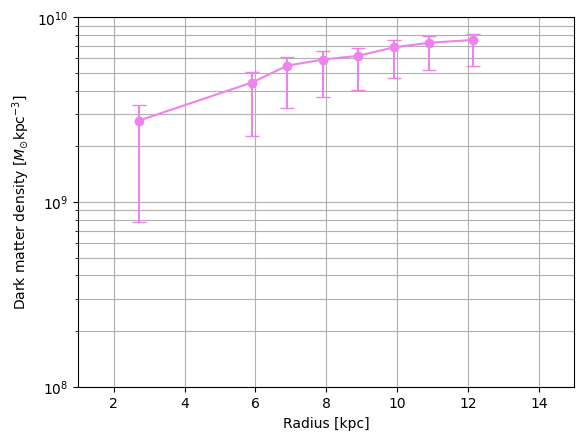

In [172]:
## DM density

DM_density, halfway_points = [], []
DM_density_upper, DM_density_lower, DM_density_upper_err, DM_density_lower_err= [], [], [], []

halfway_points.append(radius[0]/2)

i=1
while i < 8:
    halfway_points.append( (radius[i]+radius[i-1])/2 )
    i=i+1

for i in range(len(radius)):
    DM_density.append(DM[i]/radius[i])
    DM_density_lower.append(DM_lower[i]/radius[i])
    DM_density_upper.append(DM_upper[i]/radius[i])

for i in range(len(radius)):
    DM_density_lower_err.append(DM_density[i]-DM_density_lower[i])
    DM_density_upper_err.append(DM_density_upper[i]-DM_density[i])

fig, ax = plt.subplots()
plt.xlabel('Radius [kpc]')
plt.ylabel(r'Dark matter density [$M_{\odot}\text{kpc}^{-3}$]')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')
#ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1e8, 1e10)
plt.xlim(1,15)

plt.plot(halfway_points, DM_density, linewidth=1.5, color='violet')
plt.errorbar(halfway_points, DM_density, yerr=[DM_density_lower_err, DM_density_upper_err], fmt='o', capsize=5, color='violet')
plt.savefig('./figures/dark density.pdf',dpi=100,bbox_inches='tight')
plt.show()

rc: 146271.89819077597 +- 1771252778964.5583
rho: 5747771305.167135 +- 1062958189.4806889


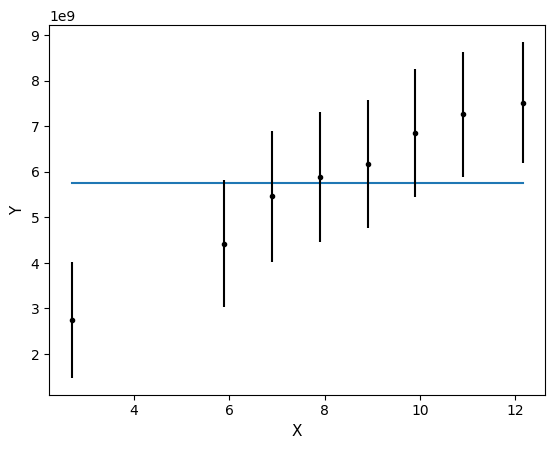

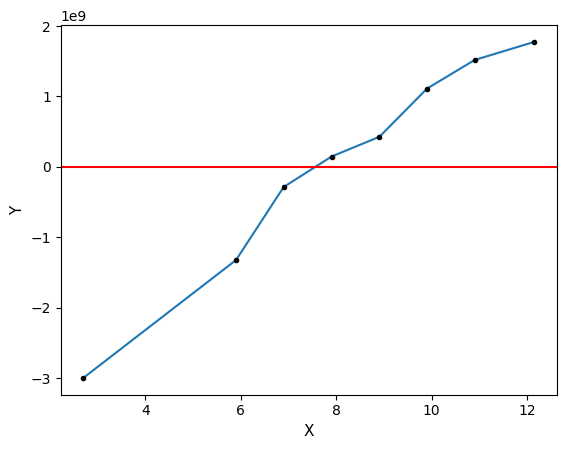

In [176]:
## PIH fitting

yerr = []
xdata = np.array(halfway_points)
ydata = np.array(DM_density)

for i in range(len(DM_density)):
    yerr.append( (DM_density_lower_err[i]+DM_density_upper_err[i]) / 2 )

def func(r,rc,rho):
    return rho / ( 1 + (r/rc)**2 )

initialguess = [1,1e8]                     # initial guess for the parameters of the function func
                                         # Make sure your guesses are in the order of the dependent variables in your function definition

fit, covariance = optimize.curve_fit(             # call to the fitting routine curve_fit.  Returns optimal values of the fit parameters, and their estimated variance
        func,                                     # function to fit
        xdata,                                    # data for independant variable
        ydata,                                    # data for dependant variable
        initialguess,                             # initial guess of fit parameters
        yerr)                                     # uncertainty in dependant variable.  Remove if you already removed yerr

print("rc:",fit[0],"+-",np.sqrt(covariance[0][0]))     #print value and one std error of the first fit parameter
print("rho:",fit[1],"+-",np.sqrt(covariance[1][1]))     #print value and one std error of the second fit parameter.

##########
# Plotting data and fit
##########

xdatafit=np.linspace(min(xdata), max(xdata), 100) # make lots of xdata for a smooth curve
func_plot=func(xdatafit,*fit)                     # create discrete data set from fitting function

plt.clf()                                         # clear plot figure
plt.plot(xdatafit, func_plot)                     # plot the fit function
plt.errorbar(xdata, ydata, yerr, fmt='k.')
plt.xlabel('X',fontsize = 11)
plt.ylabel('Y',fontsize = 11)
#plt.xlim(np.min(xdata),np.max(xdata))
#plt.ylim(np.min(ydata),np.max(ydata))
#plt.savefig('./figures/PIH fit.pdf',dpi=100,bbox_inches='tight')
plt.show()

##########
# Plotting residuals
##########

func_model=func(xdata,*fit)              # create discrete data set from fitting function
residual = (ydata-func_model)                  # create array of residual data
normresidual = (ydata-func_model)/yerr         #normalize residual data with the uncertainty in each point.  The result is the number of std errors.

plt.clf()
plt.errorbar(xdata, residual, fmt='k.')     #switch to normresidual if appropriate
plt.plot(xdata, residual)                   #switch to normresidual if appropriate
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel('X',fontsize = 11)
plt.ylabel('Y',fontsize = 11)
#plt.savefig('./figures/PIH fit res.pdf',dpi=100,bbox_inches='tight')
plt.show()